In [1]:
import sympy as sym
from sympy import Matrix
from statics.mitroiki_functs import K_with_axial
from statics.mitroiki_functs import round_expr

import openseespy.opensees as ops
import opsvis as opsv
import matplotlib.pyplot as plt

from IPython.display import Image

# Εφαρμογή 7

Να υπολογιστούν οι αντιδράσεις στήριξης, οι παραμορφώσεις και τα διαγράμματα των εντατικών μεγεθών για τον φορέα του σχήματος.

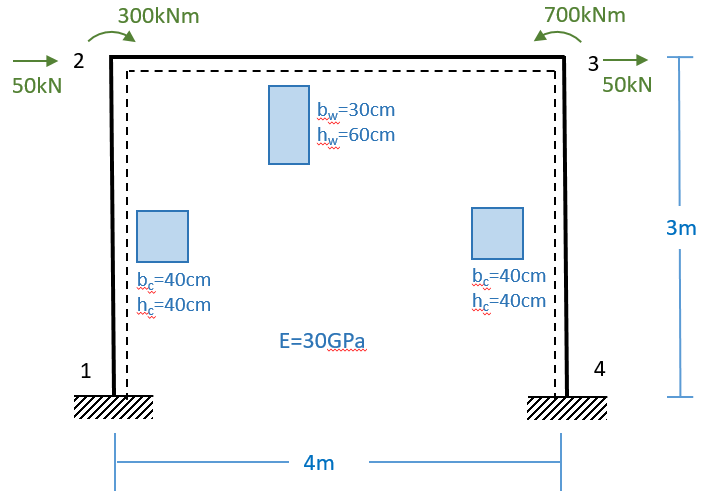

In [2]:
Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/example7/ekfonisi.png", width=600)

In [3]:
E = 30_000_000.

bw = 0.30
hw = 0.60

bc = 0.40
hc = 0.40

Iw = bw * hw**3 / 12
Aw = bw * hw

Ic = bc * hc**3 / 12
Ac = bc * hc

Lx = 4.0
Ly = 3.0

F2 = F3 = 50.
M2 = -300
M3 = 700

## Αντιστοίχιση τοπικών - καθολικών βαθμών ελευθερίας

| Καθολ. Συστ. | (1) | (2) | (3) | (4) | (5) | (6) | (7) | (8) | (9) | (10) | (11) | (12) |
|--------------|-----|-----|-----|-----|-----|-----|-----|-----|-----|------|------|------|
| 1-2          | -2  |  1  |  3  | -5  |  4  |  6  |     |     |     |      |      |      |
| 2-3          |     |     |     |  1  |  2  |  3  |  4  |  5  |  6  |      |      |      |
| 3-4          |     |     |     |     |     |     |  2  | -1  |  3  |  5   | -4   |  6   |

<!-- <img src="img\dof_global_local.png" width="650"> -->

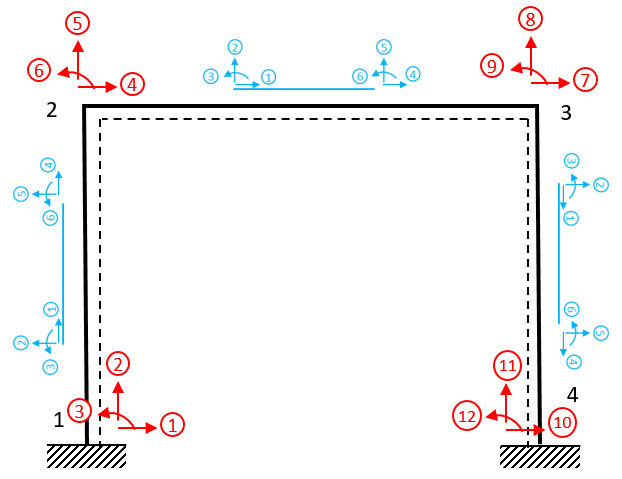

In [4]:
Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/example7/dof_global_local.png", width=550)

## Μητρώα στιβαρότητας στοιχείων
Τα στοιχεία 1 και 3 έχουν όμοια μητρώα στιβαρότητας

In [5]:
K1 = K3 = K_with_axial(E=E, A=Ac, I=Ic, L=Ly)
round_expr(K1, 1)

Matrix([
[ 1600000.0,        0,        0, -1600000.0,        0,        0],
[         0,  28444.4,  42666.7,          0, -28444.4,  42666.7],
[         0,  42666.7,  85333.3,          0, -42666.7,  42666.7],
[-1600000.0,        0,        0,  1600000.0,        0,        0],
[         0, -28444.4, -42666.7,          0,  28444.4, -42666.7],
[         0,  42666.7,  42666.7,          0, -42666.7,  85333.3]])

In [6]:
K2 = K_with_axial(E=E, A=Aw, I=Iw, L=Lx)
round_expr(K2, 1)

Matrix([
[ 1350000.0,        0,        0, -1350000.0,        0,        0],
[         0,  30375.0,  60750.0,          0, -30375.0,  60750.0],
[         0,  60750.0, 162000.0,          0, -60750.0,  81000.0],
[-1350000.0,        0,        0,  1350000.0,        0,        0],
[         0, -30375.0, -60750.0,          0,  30375.0, -60750.0],
[         0,  60750.0,  81000.0,          0, -60750.0, 162000.0]])

## Μητρώο στιβαρότητας φορέα
Είναι διαστάσεων 12x12 και δημιουργείται από το συνδυασμό των επιμέρους μητρώων, βάσει της αντιστοίχισης των βαθμών ελευθερίας στο καθολικό σύστημα συντεταγμένων

Δημιουργείται ένα μηδενικό μητρώο 12x12 και σταδιακά προστίθενται οι τιμές στις κατάλληλες θέσεις

| Καθολ. Συστ. | (1) | (2) | (3) | (4) | (5) | (6) | (7) | (8) | (9) | (10) | (11) | (12) |
|--------------|-----|-----|-----|-----|-----|-----|-----|-----|-----|------|------|------|
| 1-2          | -2  |  1  |  3  | -5  |  4  |  6  |     |     |     |      |      |      |
| 2-3          |     |     |     |  1  |  2  |  3  |  4  |  5  |  6  |      |      |      |
| 3-4          |     |     |     |     |     |     |  2  | -1  |  3  |  5   | -4   |  6   |

In [7]:
K1_temp = sym.zeros(12,12)

K1_temp[0, 0] += +K1[1, 1]
K1_temp[1, 0] += -K1[0, 1]
K1_temp[2, 0] += -K1[2, 1]
K1_temp[3, 0] += +K1[4, 1]
K1_temp[4, 0] += -K1[3, 1]
K1_temp[5, 0] += -K1[5, 1]

K1_temp[0, 1] += -K1[1, 0]
K1_temp[1, 1] += +K1[0, 0]
K1_temp[2, 1] += +K1[2, 0]
K1_temp[3, 1] += -K1[4, 0]
K1_temp[4, 1] += +K1[3, 0]
K1_temp[5, 1] += +K1[5, 0]

K1_temp[0, 2] += -K1[1, 2]
K1_temp[1, 2] += +K1[0, 2]
K1_temp[2, 2] += +K1[2, 2]
K1_temp[3, 2] += -K1[4, 2]
K1_temp[4, 2] += +K1[3, 2]
K1_temp[5, 2] += +K1[5, 2]

K1_temp[0, 3] += +K1[1, 4]
K1_temp[1, 3] += -K1[0, 4]
K1_temp[2, 3] += -K1[2, 4]
K1_temp[3, 3] += +K1[4, 4]
K1_temp[4, 3] += -K1[3, 4]
K1_temp[5, 3] += -K1[5, 4]

K1_temp[0, 4] += -K1[1, 3]
K1_temp[1, 4] += +K1[0, 3]
K1_temp[2, 4] += +K1[2, 3]
K1_temp[3, 4] += -K1[4, 3]
K1_temp[4, 4] += +K1[3, 3]
K1_temp[5, 4] += +K1[5, 3]

K1_temp[0, 5] += -K1[1, 5]
K1_temp[1, 5] += +K1[0, 5]
K1_temp[2, 5] += +K1[2, 5]
K1_temp[3, 5] += -K1[4, 5]
K1_temp[4, 5] += +K1[3, 5]
K1_temp[5, 5] += +K1[5, 5]

round_expr(K1_temp, 1)

Matrix([
[ 28444.4,          0, -42666.7, -28444.4,          0, -42666.7, 0, 0, 0, 0, 0, 0],
[       0,  1600000.0,        0,        0, -1600000.0,        0, 0, 0, 0, 0, 0, 0],
[-42666.7,          0,  85333.3,  42666.7,          0,  42666.7, 0, 0, 0, 0, 0, 0],
[-28444.4,          0,  42666.7,  28444.4,          0,  42666.7, 0, 0, 0, 0, 0, 0],
[       0, -1600000.0,        0,        0,  1600000.0,        0, 0, 0, 0, 0, 0, 0],
[-42666.7,          0,  42666.7,  42666.7,          0,  85333.3, 0, 0, 0, 0, 0, 0],
[       0,          0,        0,        0,          0,        0, 0, 0, 0, 0, 0, 0],
[       0,          0,        0,        0,          0,        0, 0, 0, 0, 0, 0, 0],
[       0,          0,        0,        0,          0,        0, 0, 0, 0, 0, 0, 0],
[       0,          0,        0,        0,          0,        0, 0, 0, 0, 0, 0, 0],
[       0,          0,        0,        0,          0,        0, 0, 0, 0, 0, 0, 0],
[       0,          0,        0,        0,          0,        0, 0,

In [8]:
K2_temp = sym.zeros(12,12)

K2_temp[3:9, 3:9] += K2

round_expr(K2_temp, 1)

Matrix([
[0, 0, 0,          0,        0,        0,          0,        0,        0, 0, 0, 0],
[0, 0, 0,          0,        0,        0,          0,        0,        0, 0, 0, 0],
[0, 0, 0,          0,        0,        0,          0,        0,        0, 0, 0, 0],
[0, 0, 0,  1350000.0,        0,        0, -1350000.0,        0,        0, 0, 0, 0],
[0, 0, 0,          0,  30375.0,  60750.0,          0, -30375.0,  60750.0, 0, 0, 0],
[0, 0, 0,          0,  60750.0, 162000.0,          0, -60750.0,  81000.0, 0, 0, 0],
[0, 0, 0, -1350000.0,        0,        0,  1350000.0,        0,        0, 0, 0, 0],
[0, 0, 0,          0, -30375.0, -60750.0,          0,  30375.0, -60750.0, 0, 0, 0],
[0, 0, 0,          0,  60750.0,  81000.0,          0, -60750.0, 162000.0, 0, 0, 0],
[0, 0, 0,          0,        0,        0,          0,        0,        0, 0, 0, 0],
[0, 0, 0,          0,        0,        0,          0,        0,        0, 0, 0, 0],
[0, 0, 0,          0,        0,        0,          0,        0,    

In [9]:
K3_temp = sym.zeros(12,12)

K3_temp[0+6, 0+6] += +K1[1, 1]
K3_temp[1+6, 0+6] += -K1[0, 1]
K3_temp[2+6, 0+6] += +K1[2, 1]
K3_temp[3+6, 0+6] += +K1[4, 1]
K3_temp[4+6, 0+6] += -K1[3, 1]
K3_temp[5+6, 0+6] += +K1[5, 1]

K3_temp[0+6, 1+6] += -K1[1, 0]
K3_temp[1+6, 1+6] += +K1[0, 0]
K3_temp[2+6, 1+6] += -K1[2, 0]
K3_temp[3+6, 1+6] += -K1[4, 0]
K3_temp[4+6, 1+6] += +K1[3, 0]
K3_temp[5+6, 1+6] += -K1[5, 0]

K3_temp[0+6, 2+6] += +K1[1, 2]
K3_temp[1+6, 2+6] += -K1[0, 2]
K3_temp[2+6, 2+6] += +K1[2, 2]
K3_temp[3+6, 2+6] += +K1[4, 2]
K3_temp[4+6, 2+6] += -K1[3, 2]
K3_temp[5+6, 2+6] += +K1[5, 2]

K3_temp[0+6, 3+6] += +K1[1, 4]
K3_temp[1+6, 3+6] += -K1[0, 4]
K3_temp[2+6, 3+6] += +K1[2, 4]
K3_temp[3+6, 3+6] += +K1[4, 4]
K3_temp[4+6, 3+6] += -K1[3, 4]
K3_temp[5+6, 3+6] += +K1[5, 4]

K3_temp[0+6, 4+6] += -K1[1, 3]
K3_temp[1+6, 4+6] += +K1[0, 3]
K3_temp[2+6, 4+6] += -K1[2, 3]
K3_temp[3+6, 4+6] += -K1[4, 3]
K3_temp[4+6, 4+6] += +K1[3, 3]
K3_temp[5+6, 4+6] += -K1[5, 3]

K3_temp[0+6, 5+6] += +K1[1, 5]
K3_temp[1+6, 5+6] += -K1[0, 5]
K3_temp[2+6, 5+6] += +K1[2, 5]
K3_temp[3+6, 5+6] += +K1[4, 5]
K3_temp[4+6, 5+6] += -K1[3, 5]
K3_temp[5+6, 5+6] += +K1[5, 5]

round_expr(K3_temp, 1)

Matrix([
[0, 0, 0, 0, 0, 0,        0,          0,        0,        0,          0,        0],
[0, 0, 0, 0, 0, 0,        0,          0,        0,        0,          0,        0],
[0, 0, 0, 0, 0, 0,        0,          0,        0,        0,          0,        0],
[0, 0, 0, 0, 0, 0,        0,          0,        0,        0,          0,        0],
[0, 0, 0, 0, 0, 0,        0,          0,        0,        0,          0,        0],
[0, 0, 0, 0, 0, 0,        0,          0,        0,        0,          0,        0],
[0, 0, 0, 0, 0, 0,  28444.4,          0,  42666.7, -28444.4,          0,  42666.7],
[0, 0, 0, 0, 0, 0,        0,  1600000.0,        0,        0, -1600000.0,        0],
[0, 0, 0, 0, 0, 0,  42666.7,          0,  85333.3, -42666.7,          0,  42666.7],
[0, 0, 0, 0, 0, 0, -28444.4,          0, -42666.7,  28444.4,          0, -42666.7],
[0, 0, 0, 0, 0, 0,        0, -1600000.0,        0,        0,  1600000.0,        0],
[0, 0, 0, 0, 0, 0,  42666.7,          0,  42666.7, -42666.7,       

Οπότε το συνολικό μητρώο του φορέα είναι το $Κ$

In [10]:
K = K1_temp + K2_temp + K3_temp
round_expr(K, 1)

Matrix([
[ 28444.4,          0, -42666.7,   -28444.4,          0, -42666.7,          0,          0,        0,        0,          0,        0],
[       0,  1600000.0,        0,          0, -1600000.0,        0,          0,          0,        0,        0,          0,        0],
[-42666.7,          0,  85333.3,    42666.7,          0,  42666.7,          0,          0,        0,        0,          0,        0],
[-28444.4,          0,  42666.7,  1378444.4,          0,  42666.7, -1350000.0,          0,        0,        0,          0,        0],
[       0, -1600000.0,        0,          0,  1630375.0,  60750.0,          0,   -30375.0,  60750.0,        0,          0,        0],
[-42666.7,          0,  42666.7,    42666.7,    60750.0, 247333.3,          0,   -60750.0,  81000.0,        0,          0,        0],
[       0,          0,        0, -1350000.0,          0,        0,  1378444.4,          0,  42666.7, -28444.4,          0,  42666.7],
[       0,          0,        0,          0,   -30375

## Μητρώο εξωτερικής φόρτισης

Η εξωτερική φόρτιση αποτελείται από επικόμβια φορτία μόνο, τα οποία ασκούνται στους κόμβους 2 και 3.

Παρατηρείται ότι στο καθολικό σύστημα συντεταγμένων τα φορτία αυτά έχουν όλα θετικό πρόσημο, εκτός από τη ροπή στον κόμβο 2.

In [11]:
P = Matrix([[0],
            [0],
            [0],
            [50],
            [0],
            [-300],
            [50],
            [0],
            [700],
            [0],
            [0],
            [0]])

round_expr(P, 2)

Matrix([
[   0],
[   0],
[   0],
[  50],
[   0],
[-300],
[  50],
[   0],
[ 700],
[   0],
[   0],
[   0]])

## Δεσμευμένοι και ελεύθεροι βαθμοί ελευθερίας

Οι δεσμευμένοι βαθμοί ελευθερίας (με κόκκινο) οφείλονται στις πακτώσεις στους κόμβους 1 και 4, ενώ οι βαθμοί ελευθερίας 4-9 είναι αδέσμευτοι.

## Διαχωρισμός μητρώων

| Καθολ. Συστ. | <span style="color:red">(1)</span>  | <span style="color:red">(2)</span> | <span style="color:red">(3)</span> | <span style="color:blue">(4)</span>  | <span style="color:blue">(5)</span>  | <span style="color:blue">(6)</span>  | <span style="color:blue">(7)</span> | <span style="color:blue">(8)</span>  | <span style="color:blue">(9)</span>  | <span style="color:red">(10)</span>  | <span style="color:red">(11)</span>  | <span style="color:red">(12)</span>  |
|--------------|-----|-----|-----|-----|-----|-----|-----|-----|-----|------|------|------|
| 1-2          | -2  |  1  |  3  | -5  |  4  |  6  |     |     |     |      |      |      |
| 2-3          |     |     |     |  1  |  2  |  3  |  4  |  5  |  6  |      |      |      |
| 3-4          |     |     |     |     |     |     |  2  | -1  |  3  |  5   | -4   |  6   |


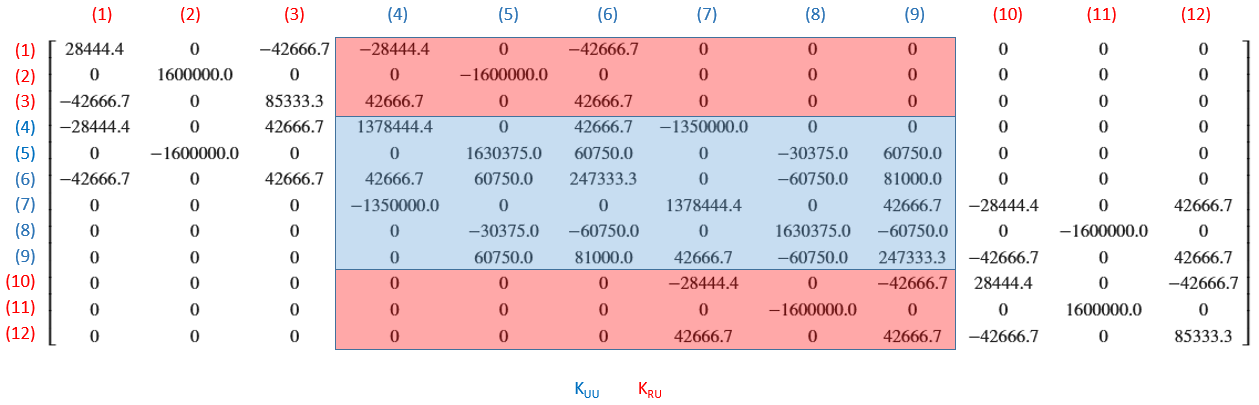

In [12]:
Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/example7/Kuu_vs_Kru.png", width=1100)

Ομοίως και για τα μητρώα εξωτερικής φόρτισης, παραμορφώσεων και αντιδράσεων
<!-- <img src="img\PUR.png" width="750"> -->

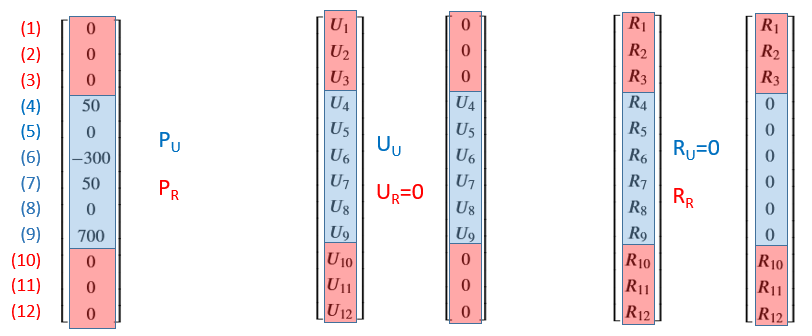

In [13]:
Image("https://raw.githubusercontent.com/panagop/ihu_courses/main/shared/images/mitroa/example7/PUR.png", width=700)

### Υπομητρώα στιβαρότητας

In [14]:
K_UU = K[[3,4,5,6,7,8], [3,4,5,6,7,8]]
round_expr(K_UU, 1)

Matrix([
[ 1378444.4,         0,  42666.7, -1350000.0,         0,        0],
[         0, 1630375.0,  60750.0,          0,  -30375.0,  60750.0],
[   42666.7,   60750.0, 247333.3,          0,  -60750.0,  81000.0],
[-1350000.0,         0,        0,  1378444.4,         0,  42666.7],
[         0,  -30375.0, -60750.0,          0, 1630375.0, -60750.0],
[         0,   60750.0,  81000.0,    42666.7,  -60750.0, 247333.3]])

Παρατηρείται ότι το μητρώο $K_{UU}$ στην περίπτωσή μας είναι απλά ένας αριθμος

In [15]:
K_RU = K[[0, 1, 2, 9, 10, 11], [3,4,5,6,7,8]]
round_expr(K_RU, 1)

Matrix([
[-28444.4,          0, -42666.7,        0,          0,        0],
[       0, -1600000.0,        0,        0,          0,        0],
[ 42666.7,          0,  42666.7,        0,          0,        0],
[       0,          0,        0, -28444.4,          0, -42666.7],
[       0,          0,        0,        0, -1600000.0,        0],
[       0,          0,        0,  42666.7,          0,  42666.7]])

### Υπομητρώα εξωτερικής φόρτισης

In [16]:
P_U = P[[3,4,5,6,7,8], 0]
round_expr(P_U, 2)

Matrix([
[  50],
[   0],
[-300],
[  50],
[   0],
[ 700]])

In [17]:
P_R = P[[0, 1, 2, 9, 10, 11], 0]
round_expr(P_R, 2)

Matrix([
[0],
[0],
[0],
[0],
[0],
[0]])

## Υπολογισμός παραμορφώσεων

Είναι $K_{UU}\cdot U_U = P_U + R_U$, με $R_U=0$

οπότε $K_{UU}\cdot U_U = P_U$

και τελικά $U_U = K_{UU}^{-1}\cdot P_U$

In [18]:
U_U = K_UU.inv() * P_U
round_expr(U_U, 7)

Matrix([
[  0.001071],
[  -3.58e-5],
[-0.0025288],
[ 0.0009766],
[   3.58e-5],
[ 0.0035075]])

## Υπολογισμός αντιδράσεων στήριξης

Είναι $K_{RU}\cdot U_U = P_R + R_R$

οπότε $R_R = K_{RU}\cdot U_U - P_R$

In [19]:
R_R = K_RU*U_U - P_R
round_expr(R_R, 2)

Matrix([
[  77.43],
[  57.28],
[  -62.2],
[-177.43],
[ -57.28],
[ 191.32]])

## Επίλυση/έλεγχος με το OpenSees

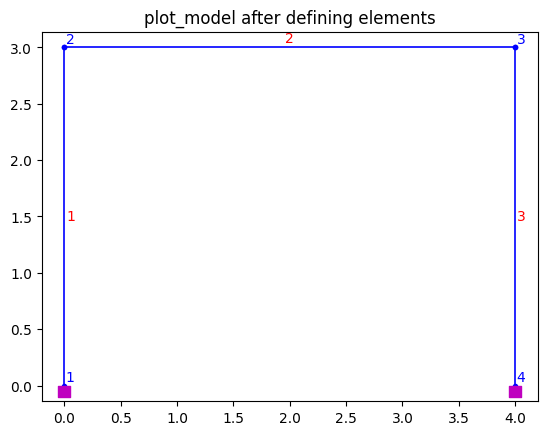

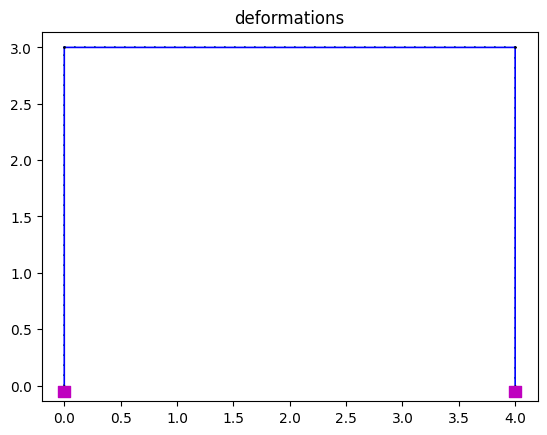

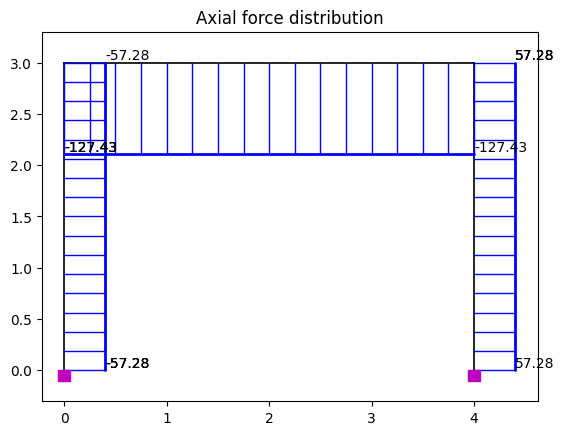

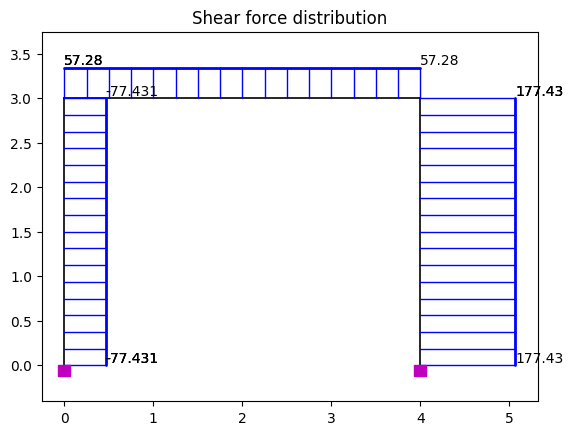

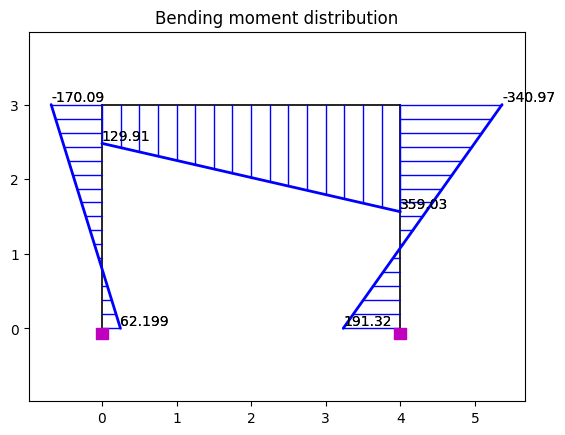

In [20]:
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

ops.node(1, 0., 0)
ops.node(2, 0, Ly)
ops.node(3, Lx, Ly)
ops.node(4, Lx, 0)

ops.fix(1, 1, 1, 1)
ops.fix(4, 1, 1, 1)

# opsv.plot_model()
# plt.title('plot_model before defining elements')

ops.geomTransf('Linear', 1)

# elements
ops.element('elasticBeamColumn', 1, 1, 2, Ac, E, Ic, 1)
ops.element('elasticBeamColumn', 2, 2, 3, Aw, E, Iw, 1)
ops.element('elasticBeamColumn', 3, 3, 4, Ac, E, Ic, 1)


# loads
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)

# ops.eleLoad('-ele', 1, '-type', '-beamPoint', -F_load, 0.5)
ops.load(2, F2, 0, M2)
ops.load(3, F3, 0, M3)



# analysis
ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

# results
# ops.printModel()
opsv.plot_model()
plt.title('plot_model after defining elements')

# opsv.plot_loads_2d()
# plt.title('loads')

sfac = .1
opsv.plot_defo(sfac)
plt.title('deformations')

sfacN, sfacV, sfacM = 7.e-3, 6.e-3, 4.e-3
opsv.section_force_diagram_2d('N', sfacN)
plt.title('Axial force distribution')

opsv.section_force_diagram_2d('T', sfacV)
plt.title('Shear force distribution')

opsv.section_force_diagram_2d('M', sfacM)
plt.title('Bending moment distribution')


plt.show()


In [21]:
# U1, U2, U3, U4, U5, U6, U7, U8, U9, U10, U11, U12 = sym.symbols('U1 U2 U3 U4 U5 U6 U7 U8 U9 U10 U11 U12')
# P1, P2, P3, P4, P5, P6, P7, P8, P9, P10, P11, P12 = sym.symbols('P1 P2 P3 P4 P5 P6 P7 P8 P9 P10 P11 P12')
# R1, R2, R3, R4, R5, R6, R7, R8, R9, R10, R11, R12 = sym.symbols('R1 R2 R3 R4 R5 R6 R7 R8 R9 R10 R11 R12')

In [22]:
# U = Matrix([[U1], [U2], [U3], [U4], [U5], [U6], [U7], [U8], [U9], [U10], [U11], [U12]])
# U

In [23]:
# U.subs(U1, 0).subs(U2, 0).subs(U3, 0).subs(U10, 0).subs(U11, 0).subs(U12, 0)

In [24]:
# P = Matrix([[P1], [P2], [P3], [P4], [P5], [P6], [P7]])
# P

In [25]:
# R = Matrix([[R1], [R2], [R3], [R4], [R5], [R6], [R7], [R8], [R9], [R10], [R11], [R12]])
# R

In [26]:
# R.subs(R4, 0).subs(R5, 0).subs(R6, 0).subs(R7, 0).subs(R8, 0).subs(R9, 0)